In [1]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from img2vec_pytorch import Img2Vec
from matplotlib import pyplot as plt
from PIL import Image
import tempfile
import numpy as np
import pandas as pd
import os
import re

In [2]:
IMG_DIR = 'images-final'
FUNDING_INFO = 'fund_info.csv'

fnames = os.listdir(IMG_DIR)
fnames.sort() # so loads in same order every time
fpaths = [os.path.join(IMG_DIR, f) for f in fnames if 'png' in f]

The stimulus consists of an image and a text snippet, which are both kept in a single `.png` file. The top of the `.png` file contains only the image, which is all that's been shown to the subject in the EEG analysis window.

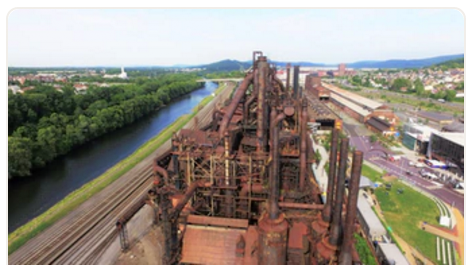

In [3]:
temp_dir = tempfile.TemporaryDirectory()
imgs = [Image.open(f).convert('RGB') for f in fpaths]
width = np.array([img.size[0] for img in imgs])
left = np.zeros_like(width)
top = np.zeros_like(width)
right = width
bottom = np.full_like(width, 265)
new_imgs = []
for i, img in enumerate(imgs):
    # crop out text
    im_new = img.crop((left[i], top[i], right[i], bottom[i]))
    # convert to jpeg
    im_new.save(os.path.join(temp_dir.name, '%d.jpg'%i))
    # reshape to match AlexNet's input shape
    im_new.resize((244, 244))
    new_imgs.append(im_new)
    
new_imgs[-1] # show an example image

We will extract a vector representation of high-level image features by taking the activations of the penultimate layer of AlexNet, a popular pre-trained image recognition model. (Object categories should be linearly readable from this layer.)

In [4]:
# construct predictor matrix, X
img2vec = Img2Vec(cuda = False, model = 'alexnet')
vecs = [img2vec.get_vec(im, tensor = False) for im in new_imgs]
temp_dir.cleanup()
X = np.stack(vecs, axis = 0)
X.shape

(91, 4096)

In [5]:
# construct funding outcome array, y
df = pd.read_csv(FUNDING_INFO)
mapping = {df.id[i]: df.funded[i] for i in range(df.shape[0])}
names = [re.findall('([\w|-]+).png', f)[0] for f in fnames]
names = [nm.replace('-', '') for nm in names]
funded = [mapping[nm] for nm in names]
y = np.array(funded)

In [6]:
def ttest_1samp_kx2cv(scores, chance = 0.5):
    '''
    Input: list of k (2, n_tests) arrays of scores obtained from
            a series of k different 2-fold cross validation splits
            
    Output: t-values, p-values, and standard errors from 
            a kx2 t-test for classification metrics with null
            hypothesis that metric == 0.5. These are all
            (n_tests,) arrays. Test described in [1].
            
    References
    ----------
    [1] Dietterich TG (1998) Approximate Statistical Tests for 
        Comparing Supervised Classification Learning Algorithms.
        Neural Comput 10:1895–1923.
    '''
    from scipy.stats import t as t_dist
    above_chance = [(scrs - chance) for scrs in scores]
    if above_chance[0].ndim == 1:
        above_chance = [ac[:, np.newaxis] for ac in above_chance]
    # estimate standard error from all the splits
    s2 = [np.square(scrs - scrs.mean(0)).sum(0) for scrs in above_chance]
    s2 = np.stack(s2, axis = 0)
    # but only use first split for observed value since scores on CV splits
    p1 = above_chance[0][0, :] # are not truly independent of one another.
    se = np.sqrt(s2.mean(0)) # see [1]
    # after that, it's just a normal t-test
    t = p1 / se
    p = t_dist.sf(t, df = s2.shape[0]) # one-sided p-value 
    return t, p, (p1 + chance), se

We want to assess how well a single linear dimension in the space of high-level visual features that can differentiate between funded and unfunded stimuli. On each training set, we identify the dimension that best differentiates between the stimuli using Fisher's Linear Discriminant Analysis (LDA), and we evaluate how well this bifurcation generalizes to a hold-out set.

In [7]:
# define model
lda = LinearDiscriminantAnalysis(n_components = 1)

# cross validate
metric = 'roc_auc'
cv_methds = [StratifiedKFold(2, shuffle = True, random_state = i) for i in range(10)]
scores = [cross_val_score(lda, X, y, cv = cv, scoring = metric) for cv in cv_methds]

# test CV score against null hypothesis AUC == 0.5
t, p, m, se = ttest_1samp_kx2cv(scores)

print(metric + ' = {:.2f} +/- {:.2f},'.format(m[0], 1.96*se[0]))
print('t({:d}) = {:.3f}, p = {:.3f}'.format(len(scores), t[0], p[0]))

roc_auc = 0.49 +/- 0.10,
t(10) = -0.241, p = 0.593


In [8]:
scores # scores obtained across iterations

[array([0.48771267, 0.45849802]),
 array([0.46691871, 0.46047431]),
 array([0.39508507, 0.42687747]),
 array([0.56143667, 0.53359684]),
 array([0.53308129, 0.42687747]),
 array([0.37240076, 0.48023715]),
 array([0.53119093, 0.48814229]),
 array([0.42911153, 0.53952569]),
 array([0.6389414 , 0.53162055]),
 array([0.43667297, 0.40711462])]